In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor, gen_loss_function
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from tqdm import tqdm
from itertools import product

In [2]:
import os 
os.getcwd()

'/Users/theosmith/Documents/MPhys_YiER_Project/Coding/Git_repo/THz-TDS/Transfer Matrix Method'

Length of pulse array: 701
Bias: -0.18446526495726498


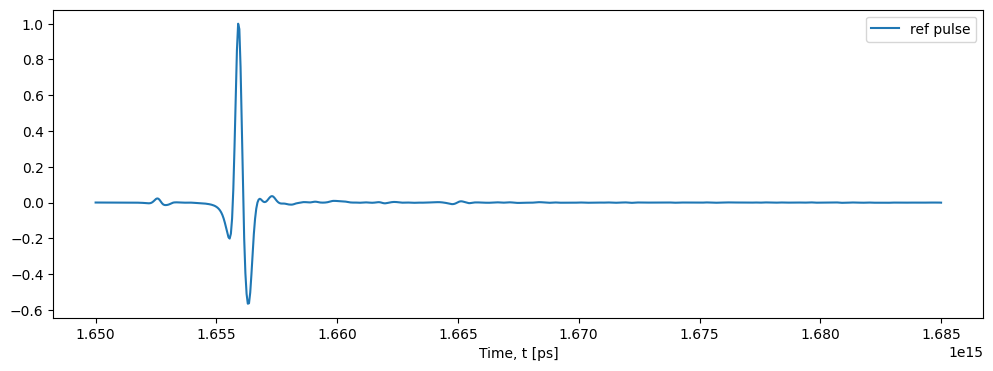

In [3]:
ref_path = 'data/example_ref_pulse.csv'
ref_df = pd.read_csv(ref_path)
t_axis = ref_df['Time_abs/ps'].to_numpy()
reference_pulse = ref_df[' Signal/nA'].to_numpy()

## Remove Dc bias
halfway = len(reference_pulse) // 2
# Calculate the mean of the second half (assumed baseline)
bias = np.mean(reference_pulse[halfway:])
# Subtract the bias from the entire signal
reference_pulse = reference_pulse - bias

# Normalize reference pulse
peak_val_ref = max(reference_pulse)
reference_pulse = reference_pulse / peak_val_ref

# Find signal length (in num points)
L = len(reference_pulse)
print(f'Length of pulse array: {L}')

print(f'Bias: {bias}')
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [4]:
## Check time steps are consistent in t_axis

# Compute time differences between consecutive samples
dt = np.diff(t_axis)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

Time steps are uniform: True
delta_t: 0.049999999999954525 ps


## Test Single layer simulated sample with experimental reference pulse

[((3.46-0.001j), 0.001)]


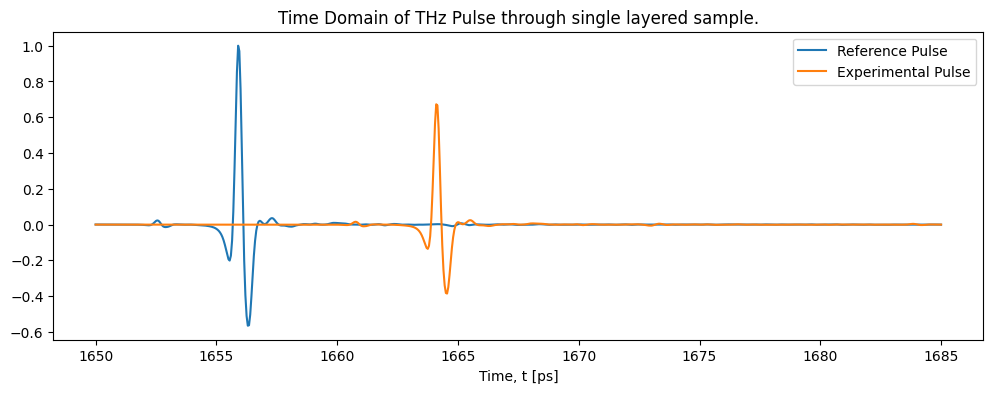

In [5]:
# Convert refence pulse to tensor
reference_pulse = torch.tensor(reference_pulse, dtype=torch.float32)

# Convert delta_t to seconds from pico seconds
deltat = deltat * 1e-12

# Material params
n1, k1, d1 = 3.46, -0.001, 1e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1)]

# Simulate the experimental data
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]


print(material_params_exp)
plt.figure(figsize=(12,4))
plt.title('Time Domain of THz Pulse through single layered sample.')
plt.plot(t_axis, reference_pulse, label='Reference Pulse')
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Perform extraction on this data 
- Only extract n and k as this is a single layer and there is not enough information to extract thickness aswell.

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (2.87, 3.4699999999999998)
Layer 1 - k ∈ (-0.0115, 0.0085)
[((3.4601443568766723-0.000984603459536491j), 0.001)]


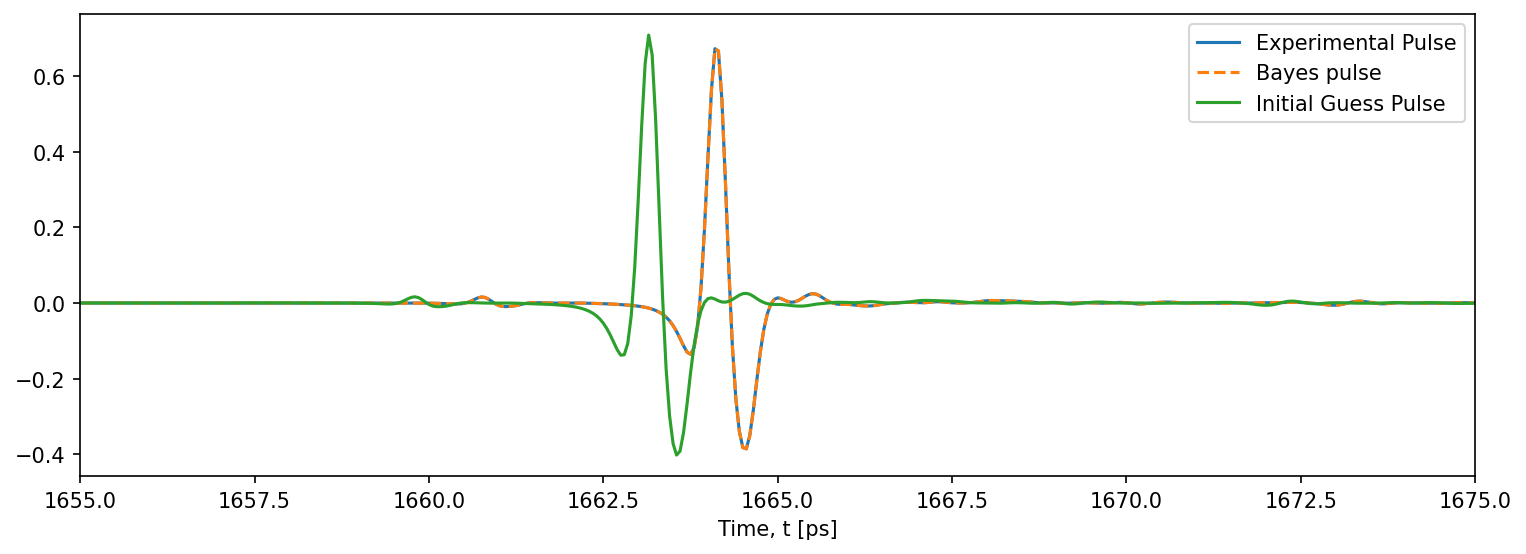

In [6]:
# set initial guesses for Bayes optimization
layers_init = [(3.17-0.0015j, 1e-3)]
optimization_bounds = [0.3, 0.01, 0.15e-3]

init_pulse = simulate_parallel(reference_pulse, layers_init, deltat, 0)[1].detach().cpu().numpy()[:L]

# Set optimization mask
optimization_mask = [(True, True, False)]
Bayes_extractor = BayesianLayeredExtractor(reference_pulse,experimental_pulse, 
                                            deltat, layers_init, optimization_mask, optimization_bounds=optimization_bounds)

bayes_params = Bayes_extractor.bayesian_optimization(n_calls=50)
bayes_pulse = simulate_parallel(reference_pulse, bayes_params, deltat, 0)[1].detach().cpu().numpy()[:L]


print(bayes_params)
plt.figure(figsize=(12,4))
#plt.plot(t_axis, reference_pulse, label='Reference Pulse', alpha=0.5)
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis, bayes_pulse, label='Bayes pulse', linestyle='--')
plt.plot(t_axis, init_pulse, label='Initial Guess Pulse')
plt.xlabel('Time, t [ps]')
plt.xlim([1655, 1675])
plt.legend()
plt.show()

Fine-tuning 2 parameters for 50 iterations.
Iteration 4, Loss: 1.177234e-04, Layer 0: n=3.4600, k=-0.00095, D=1000.00 µm
Iteration 9, Loss: 5.371560e-05, Layer 0: n=3.4600, k=-0.00101, D=1000.00 µm
Iteration 14, Loss: 2.201458e-05, Layer 0: n=3.4600, k=-0.00102, D=1000.00 µm
Iteration 19, Loss: 3.122814e-05, Layer 0: n=3.4600, k=-0.00097, D=1000.00 µm
Iteration 24, Loss: 3.839113e-05, Layer 0: n=3.4600, k=-0.00102, D=1000.00 µm
Iteration 29, Loss: 2.542347e-05, Layer 0: n=3.4600, k=-0.00100, D=1000.00 µm
Iteration 34, Loss: 1.021807e-05, Layer 0: n=3.4600, k=-0.00099, D=1000.00 µm
Iteration 39, Loss: 1.403738e-05, Layer 0: n=3.4600, k=-0.00099, D=1000.00 µm
Iteration 44, Loss: 9.404929e-06, Layer 0: n=3.4600, k=-0.00100, D=1000.00 µm
Iteration 49, Loss: 1.550125e-05, Layer 0: n=3.4600, k=-0.00100, D=1000.00 µm
[((3.459993362426758-0.0009903445607051253j), 0.0009999999310821295)]


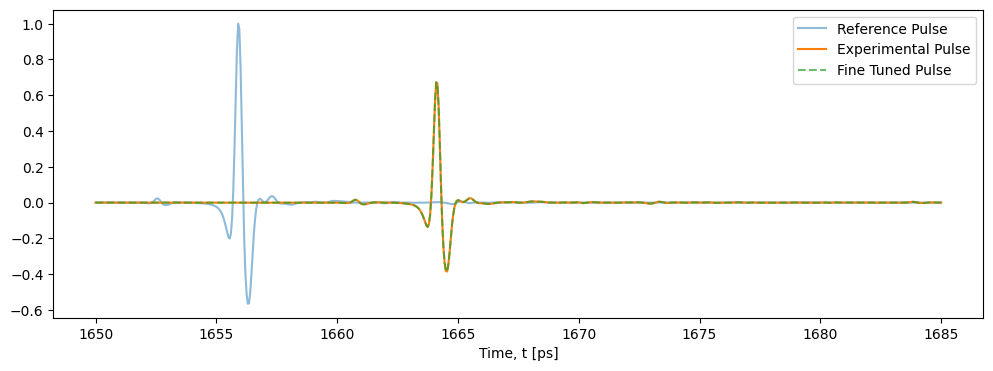

In [7]:
grad_optimizer = LayeredExtractor(reference_pulse, experimental_pulse, deltat, bayes_params, optimization_mask, lr=0.0001)
optim_params = grad_optimizer.optimize(num_iterations=50, updates=5)

optim_pulse = simulate_parallel(reference_pulse, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t_axis, reference_pulse, label='Reference Pulse', alpha=0.5)
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis, optim_pulse, label='Fine Tuned Pulse', alpha=0.7, linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [8]:
optim_params

[((3.459993362426758-0.0009903445607051253j), 0.0009999999310821295)]

In [9]:
n_residual = (np.real(material_params_exp[0][0]) - np.real(optim_params[0][0]))
k_residual = (np.imag(material_params_exp[0][0]) - np.imag(optim_params[0][0]))

print(f'n residual: {np.abs(n_residual)}')
print(f'k residual: {np.abs(k_residual)}')

print(f'n % error: {100 * np.abs(n_residual)/3.46}')
print(f'k % error: {100 * np.abs(k_residual)/0.001}')

n residual: 6.637573242151973e-06
k residual: 9.655439294874689e-06
n % error: 0.00019183737694080847
k % error: 0.9655439294874689


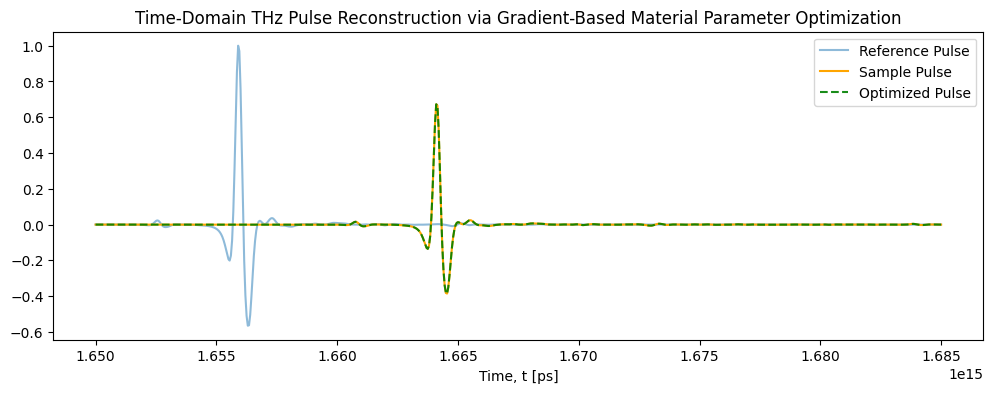

In [10]:
# Main figure
fig, ax = plt.subplots(figsize=(12, 4))

# Plotting
ax.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', alpha=0.5)
ax.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', color='orange')
ax.plot(t_axis*1e12, optim_pulse, label='Optimized Pulse', linestyle='--', color='green', alpha=0.9)

# Labels and title
ax.set_xlabel('Time, t [ps]')

ax.set_title('Time-Domain THz Pulse Reconstruction via Gradient-Based Material Parameter Optimization')
ax.legend()


plt.show()

## Plot loss landscape

In [11]:
# True values
n_true = n1
k_true = k1
d_true = d1

# Specific coords for weird loss sections (massive spikes)
"""
# Define your grid resolution
n_vals = np.linspace(3.502, 3.504, 400)
k_vals = np.linspace(0.03, 0.04, 400)
n_grid, k_grid = np.meshgrid(n_vals, k_vals)
"""

# Define your grid resolution
n_vals = np.linspace(n_true - 0.02, n_true + 0.02, 400)
k_vals = np.linspace(k_true - 0.001, k_true + 0.001, 400)
n_grid, k_grid = np.meshgrid(n_vals, k_vals)

print('Exploring parameter space:')
print(f'n lims: [{min(n_vals)}, {max(n_vals)}]')
print(f'k limits: [{min(k_vals)}, {max(k_vals)}]')

Exploring parameter space:
n lims: [3.44, 3.48]
k limits: [-0.002, 0.0]


In [12]:
loss_fn = gen_loss_function  # Accepts (y_sim, y_exp) and returns a scalar

loss_grid = np.zeros_like(n_grid)

for idx, (i, j) in enumerate(tqdm(product(range(n_grid.shape[0]), range(n_grid.shape[1])), total=n_grid.size, desc="Evaluating (n, k) grid")):
    n = n_grid[i, j]
    k = k_grid[i, j]
    
    layer = [(n + 1j * k, d1)]
    y_sim = simulate_parallel(reference_pulse, layer, deltat, noise_level=0)[1][:len(reference_pulse)]
    

    y_sim_tensor = y_sim.clone().detach()
    
    loss = loss_fn(y_sim_tensor, experimental_pulse).item()
    loss_grid[i, j] = loss

Evaluating (n, k) grid: 100%|██████████| 160000/160000 [01:03<00:00, 2528.78it/s]


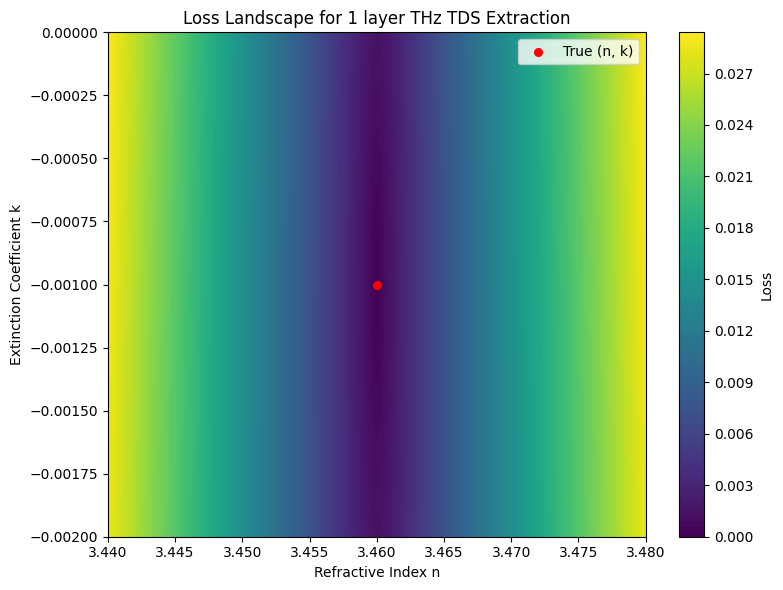

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.contourf(n_grid, k_grid, loss_grid, levels=100, cmap='viridis')
plt.colorbar(label="Loss")
plt.scatter(n_true, k_true, color='red', label="True (n, k)", s=30)
plt.xlabel("Refractive Index n")
plt.ylabel("Extinction Coefficient k")
plt.title("Loss Landscape for 1 layer THz TDS Extraction")
plt.legend()
plt.tight_layout()
plt.show()

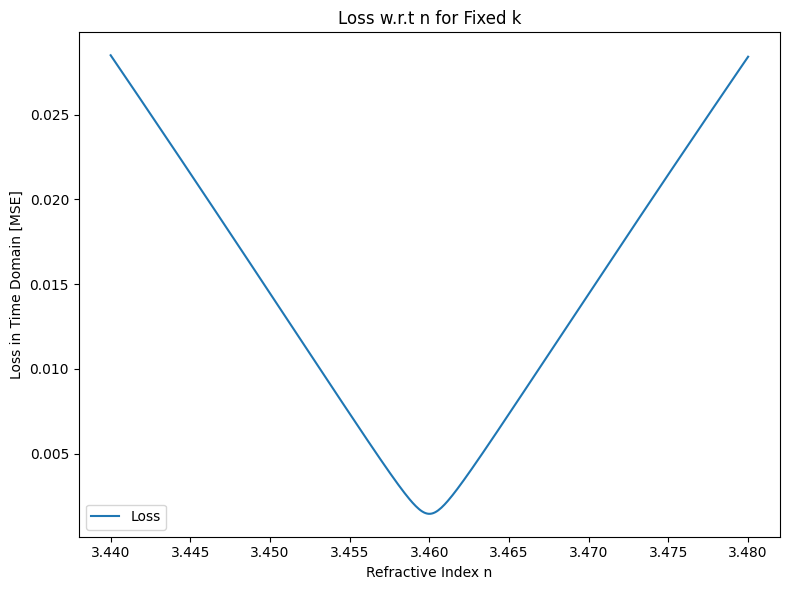

In [14]:
# Now, let's extract the loss for fixed k_true
k_index = np.argmin(np.abs(k_grid[0] - k_true))  # Find the index where k is closest to k_true
loss_at_k_true = loss_grid[k_index, :]

# Plotting the loss for fixed k
plt.figure(figsize=(8, 6))
plt.plot(n_grid[0], loss_at_k_true, label='Loss')
plt.xlabel("Refractive Index n")
plt.ylabel("Loss in Time Domain [MSE]")
plt.title("Loss w.r.t n for Fixed k")
plt.legend()
plt.tight_layout()
plt.show()

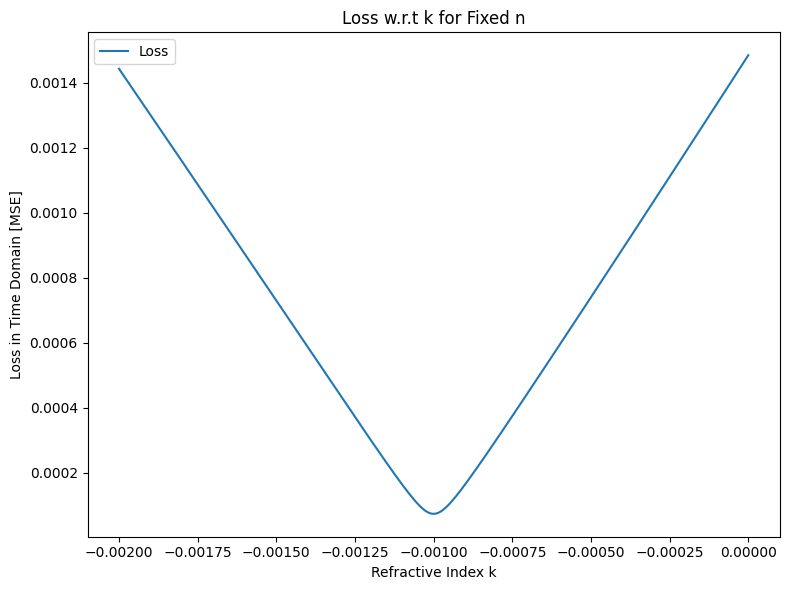

In [15]:
# Now, let's extract the loss for fixed n_true
n_index = np.argmin(np.abs(n_grid[0] - n_true))  
loss_at_n_true = loss_grid[:, n_index]

# Plotting the loss for fixed k
plt.figure(figsize=(8, 6))
plt.plot(k_grid[:, 0], loss_at_n_true, label='Loss')
plt.xlabel("Refractive Index k")
plt.ylabel("Loss in Time Domain [MSE]")
plt.title("Loss w.r.t k for Fixed n")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Define your grid resolution
n_vals = np.linspace(n_true - 0.1, n_true + 0.1, 200)
d_vals = np.linspace(d_true - 0.01e-3, d_true + 0.01e-3, 200)
n_grid, d_grid = np.meshgrid(n_vals, d_vals)

In [17]:
loss_fn = gen_loss_function  # Accepts (y_sim, y_exp) and returns a scalar

loss_grid = np.zeros_like(n_grid)

for idx, (i, j) in enumerate(tqdm(product(range(n_grid.shape[0]), range(n_grid.shape[1])), total=n_grid.size, desc="Evaluating (n, d) grid")):
    n = n_grid[i, j]
    d = d_grid[i, j]
    
    layer = [(n + 1j * k1, d)]
    y_sim = simulate_parallel(reference_pulse, layer, deltat, noise_level=0)[1][:len(reference_pulse)]
    

    y_sim_tensor = y_sim.clone().detach()
    
    loss = loss_fn(y_sim_tensor, experimental_pulse).item()
    loss_grid[i, j] = loss

Evaluating (n, d) grid: 100%|██████████| 40000/40000 [00:15<00:00, 2521.71it/s]


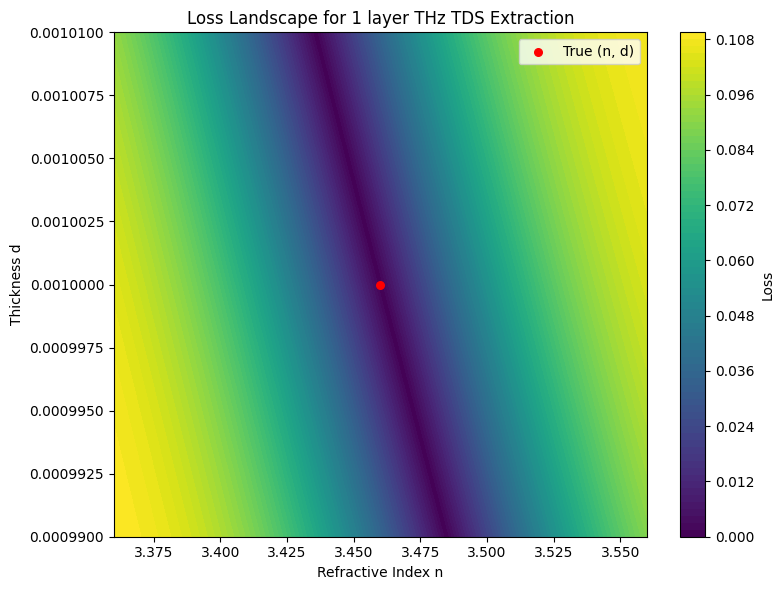

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.contourf(n_grid, d_grid, loss_grid, levels=100, cmap='viridis')
plt.colorbar(label="Loss")
plt.scatter(n_true, d_true, color='red', label="True (n, d)", s=30)
plt.xlabel("Refractive Index n")
plt.ylabel("Thickness d")
plt.title("Loss Landscape for 1 layer THz TDS Extraction")
plt.legend()
plt.tight_layout()
plt.show()